# Assignment 2: Solving memory task using the RNN
This exercise 
1. Reuses the bptt-rnn from ex1
2. Implements a generator for the memory-task, so the label is the 0th element of an otherwise random sequence
3. Implement a learner with MSE loss to test it
4. Test learner with various parameters
5. Visualize learning and MSE

In [1]:
from collections import defaultdict
from typing import Tuple, Generator, Dict, List

import matplotlib.pyplot as plt
import numpy as np
import tqdm

In [2]:
class RNN(object):
    """Numpy implementation of sequence-to-one recurrent neural network for regression tasks."""
    
    def __init__(self, input_size: int, hidden_size: int, output_size: int):
        """Initialization 

        Parameters
        ----------
        input_size : int
            Number of input features per time step
        hidden_size : int
            Number of hidden units in the RNN
        output_size : int
            Number of output units.
        """
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # create and initialize weights of the network
        self.W = np.zeros((input_size, hidden_size))
        self.R = np.zeros((hidden_size, hidden_size))
        self.bs = np.zeros((hidden_size, 1))
        self.V = np.zeros((hidden_size, output_size))
        self.by = np.zeros((output_size, 1))
        self.reset_parameters()

        # place holder to store intermediates for backprop
        self.a = None
        self.y_hat = None
        self.grads = None
        self.x = None

    def reset_parameters(self):
        """Weight initialization
        
        Initialize the recurrent weights as identity matrix and the input to hidden
        and hidden to output weights using the LeCun initialization.
        """
        # recurrent weights initialized as identity matrix
        self.R = np.eye(self.hidden_size)
        
        # input to hidden and hidden to output initialized with LeCun initialization
        gain = np.sqrt(3 / self.input_size)
        self.W = np.random.uniform(-gain, gain, self.W.shape)
        gain = np.sqrt(3 / self.hidden_size)
        self.V = np.random.uniform(-gain, gain, self.V.shape)

    def forward(self, x: np.ndarray) -> np.ndarray:
        """Forward pass through the RNN.

        Parameters
        ----------
        x : np.ndarray
            Input sequence(s) of shape [sequence length, batch size, number of features]

        Returns
        -------
        NumPy array containing the network prediction for each sample in the input data.
        """
        seq_length, batch_size, _ = x.shape

        self.a = np.zeros((seq_length+1, batch_size, self.hidden_size))

        a_0 = np.zeros((batch_size, self.hidden_size))
        self.a[-1] = a_0.copy()

        for t in range(seq_length):
            s_t = x[t] @ self.W + self.a[t-1] @ self.R + self.bs.T
            self.a[t] = np.tanh(s_t)
        
        y_hat = self.a[t] @ self.V + self.by.T
        self.y_hat = y_hat.copy()
        self.x = x.copy()

        return y_hat

    def backward(self, d_loss: np.ndarray) -> Dict:
        """Calculate the backward pass through the RNN.
        
        Parameters
        ----------
        d_loss : np.ndarray
            The gradient of the loss w.r.t the network output in the shape [batch_size, output_size]

        Returns
        -------
        Dictionary containing the gradients for each network weight as key-value pair.
        """
        seq_length, _, _ = self.x.shape

        # track gradients of weight matrices
        d_V = np.zeros_like(self.V)
        d_by = np.zeros_like(self.by)
        d_R = np.zeros((seq_length, *self.R.shape))
        d_W = np.zeros((seq_length, *self.W.shape))
        d_bs = np.zeros((seq_length, *self.bs.shape))
        
        for t in reversed(range(seq_length)):
            if t == seq_length - 1:
                d_V = self.a[t].T @ d_loss
                d_a = d_loss @ self.V.T
                d_by = d_loss.sum(axis=0).reshape(self.by.shape)
            else:
                d_a = d_a_next
            
            d_s = d_a * (1 - self.a[t]**2)
            d_W[t] = self.x[t].T @ d_s
            d_R[t] = self.a[t-1].T @ d_s
            d_bs[t] = d_s.sum(axis=0).reshape(d_bs[t].shape)

            d_a_next = d_s @ self.R.T

        self.grads = {'d_V': d_V, 'd_W': d_W, 'd_R': d_R, 'd_bs': d_bs, 'd_by': d_by}
        
        return self.grads
        
    def update(self, lr: float):
        """Updat the network parameter.
        
        Note: By convention (for numerical stabilization) the average (instead
        of the sum) gradient over time is used for updating the recurrent weights.

        Parameters
        ----------
        lr : float
            Learning rate used for the weight update
        """
        if not self.grads:
            raise RuntimeError("You have to call the .backward() function first")
            
        for key, grad in self.grads.items():
            if len(grad.shape) == 3:
                self.grads[key] = grad.sum(axis=0)
                
        self.W -= lr*self.grads['d_W']
        self.R -= lr*self.grads['d_R']
        self.V -= lr*self.grads['d_V']
        self.bs -= lr*self.grads['d_bs']
        self.by -= lr*self.grads['d_by']

        # reset internal class attributes
        self.grads = {}
        self.y_hat, self.a = None, None
        
    def get_weights(self) -> Dict:
        """Return dictionary containing the weight matrices
        
        Returns
        -------
        Dictionary containing the network weights as key-value pairs.
        """
        return {'W': self.W, 'R': self.R, 'V': self.V, 'bs': self.bs, 'by': self.by}
    
    def set_weights(self, weights: Dict):
        """Set the network weights.
        
        Parameters
        ----------
        weights : Dict
            Dictionary containing one key-value pair for each network weight.
        """
        if not all(name in weights.keys() for name in ['W', 'R', 'V']):
            raise ValueError("Missing one of 'W', 'R', 'V' keys in the weight dictionary")
        self.W = weights["W"]
        self.R = weights["R"]
        self.V = weights["V"]
        self.bs = weights["bs"]
        self.by = weights["by"]

# Implement Datagenerator
Random sequence, label is the 0th element, so you have to perfectly remember the 0th element and ignore every following up input.

In [3]:
def generate_samples(batch_size: int, seq_length: int) -> Tuple[np.ndarray, np.ndarray]:
    """Data generator for memory task
    
    Note: Implement this function as a Python generator.
    
    Parameters
    ----------
    batch_size : int
        Number of samples in one batch
    seq_length : int
        Length of sequence of random numbers
        
    Returns
    -------
    x : np.ndarray
        Array of shape [sequence length, batch size, 1], where each sample is a sequence
        of random generated numbers between -1 and 1.
    y : np.ndarray
        Array of shape [batch size, 1], where each element i contains the label corresponding
        to sample i of the input array. The label is the first element of the sequence.
    
    """
    while True:
        x = np.random.uniform(-1.0, 1.0, (seq_length, batch_size, 1))
        y = x[0,:,:]
        yield (x,y)

In [4]:
batch_size = 256
seq_length = 20
data_generator = generate_samples(batch_size=batch_size, seq_length=seq_length)
x, y = next(data_generator)
assert np.all(x[0,:,:] == y)
assert x.shape[0] == seq_length
assert x.shape[1] == batch_size
assert x.shape[2] == 1
assert y.shape[0] == x.shape[1]
assert y.shape[1] == 1
print("Data generator works as expected")

Data generator works as expected


# Implement MSE Loss

In [5]:
class MSELoss(object):
    def __init__(self):
        super(MSELoss, self).__init__()
        self.y_hat = None
        self.y_true = None
        
    def forward(self, y_hat: np.ndarray, y_true: np.ndarray) -> float:
        """Calculate the MSE loss
        
        Parameters
        ----------
        y_hat : np.ndarray
            Array containing the network predictions of shape [batch_size, 1]
        y_true : np.ndarray
            Array containing the true values of shape [batch_size, 1]
        
        Returns:
        The mean square error as a floating number.
        """
        self.y_hat = y_hat
        self.y_true = y_true       
        diff = (y_true.T-y_hat.T)**2
        return np.mean(diff.T)
    
    def backward(self) -> np.ndarray:
        """Calculate the backward pass of the MSE
        
        Returns
        -------
        The gradient w.r.t the network output of shape [batch_size, 1]
        """
        if (self.y_hat is None) or (self.y_true is None):
            raise RuntimeError("You have to call the .forward() function first")
            
        return 2 * (self.y_hat - self.y_true) / len(y_hat)

In [6]:
def get_numerical_gradient(loss_obj: MSELoss, y_hat: np.ndarray, y_true: np.ndarray,
                           eps: float=1e-7) -> np.ndarray:
    """Calculate the two-sided numerical gradient approximation.
    
    Parameters
    ----------
    loss_obj : MSELoss
        The MSELoss object
    y_hat : np.ndarray
        The network prediction of shape [batch size, number of outputs]
    y_true : np.ndarray
        The true target values of shape [batch size, number of outputs]
    eps : float
        The pertubations applied to the network predictions, by default 1e-7
   
    Returns
    -------
    A NumPy array containing the numerically approximated gradients.
    """
    numerical_gradients = np.zeros_like(y_hat)
    #########################################################################
    # TODO: Implement the two-sided numerical gradient approximation.       #
    # The specifications of the in- and output are defined in the docstring.#                                                  #
    #########################################################################    
    batch_size = len(y_hat)
    eye = np.eye(batch_size) * eps  # helper diagonal matrix filled with eps
    for i in range(batch_size):
        plus = loss_obj.forward(y_hat + eye[:,i:i+1], y_true)
        minus = loss_obj.forward(y_hat - eye[:,i:i+1], y_true)
        numerical_gradients[i,0] += (plus-minus) / (2 * eps)
    return numerical_gradients


def get_analytical_gradient(loss_obj: MSELoss, y_hat: np.ndarray, 
                            y_true: np.ndarray) -> np.ndarray:
    """Calculate the analytically derived gradients.
    
    Parameters
    ----------
    loss_obj : MSELoss
        The MSELoss object
    y_hat : np.ndarray
        The network prediction of shape [batch size, number of outputs]
    y_true : np.ndarray
        The true target values of shape [batch size, number of outputs]
        
    Returns
    -------
    A NumPy array containing the analytically derived gradients.
    """        
    _ = loss_obj.forward(y_hat, y_true)
    analytical_grads = loss_obj.backward()
            
    return analytical_grads

            
def gradient_check(loss_obj: MSELoss, y_hat: np.ndarray, y_true: np.ndarray, 
                   treshold: float = 1e-7):
    """Perform the gradient check.
    
    Parameters
    ----------
    loss_obj : MSELoss
        The MSELoss object
    y_hat : np.ndarray
        The network prediction of shape [batch size, number of outputs]
    y_true : np.ndarray
        The true target values of shape [batch size, number of outputs]
    threshold : float
        Threshold for the difference between the numerical and analytical gradients.
        By default 10e-7.
        
    """            
    numerical_grads = get_numerical_gradient(loss_obj, y_hat, y_true)
    analytical_grads = get_analytical_gradient(loss_obj, y_hat, y_true)

    difference = np.linalg.norm(numerical_grads - analytical_grads)
    if difference < treshold:
        print(f"Gradient check passed (difference {difference:.3e})")
    else:
        print(f"Gradient check failed (difference {difference:.3e})")

In [7]:
loss_obj = MSELoss()
y_hat = np.random.rand(256, 1)
y_true = np.random.rand(256, 1)
gradient_check(loss_obj, y_hat, y_true)

Gradient check passed (difference 1.144e-09)


In [8]:
class Learner(object):
    def __init__(self, model: RNN, loss_obj: MSELoss, data_generator: Generator):
        """The initialization method
        
        Parameters
        ----------
        model : RNN
            An instance of the NumPy RNN implementation.
        loss_obj: MSELoss
            An instance of the mean squared error loss class.
        data_generator : Generator
            The data generator function implemented above
        """
        self.model = model
        self.loss_obj = loss_obj
        self.data_generator = data_generator
        
        self.loss_values = {}
        self.y_hats = None
        self.y_trues = None
        
    def train(self, iter_steps: int, lr: float, log_steps: int = 50):
        """The training method.
        
        This function implements the training loop for a given number of
        iteration steps.
        
        Parameters
        ----------
        iter_steps : int
            Number of training iteration steps.
        lr : float
            Learning rate used for the weight update.
        log_steps : int
            Interval to log the training loss, by default 50.
        """
        if not self.loss_values:
            start_step = 0
        else:
            start_step = list(self.loss_values.keys())[-1]
        pbar = tqdm.tqdm_notebook(self.data_generator, total=iter_steps)
        for x, y in pbar:
            pbar.update()
            if pbar.n < iter_steps:
                y_hat = self.model.forward(x)
                loss = self.loss_obj.forward(y_hat, y)
                d_loss = self.loss_obj.backward()
                grads = self.model.backward(d_loss)
                self.model.update(lr)
                
                # log loss value
                if (pbar.n == 1) or (pbar.n % log_steps == 0):
                    self.loss_values[start_step + pbar.n] = loss
                    pbar.set_postfix_str(f"Loss: {loss:5f}", refresh=False)
            else:
                tqdm.tqdm.write("finished training")
                break
    
    def make_predictions(self, n_batches: int) -> Tuple[np.ndarray, np.ndarray]:
        """Calculate predictions for a given number of random batches.
        
        Parameters
        ----------
        n_batches : int
            Number of batches to get networks predictions for.
            
        Returns
        -------
        y_hats : np.ndarray
            NumPy array containing the concatenated network predictions for all batches.
        y_trues : np.ndarray
            NumPy array containing the concatenated true labels for all batches.
        """
        batch_size = len(next(self.data_generator)[1])
        self.y_hats = np.zeros((n_batches, batch_size, self.model.output_size))
        self.y_trues = np.zeros_like(self.y_hats)
        for batch in range(n_batches):
            x, self.y_trues[batch] = next(self.data_generator)
            self.y_hats[batch] = model.forward(x)
        return self.y_hats, self.y_trues
                    
    def plot_loss(self, figsize: Tuple[float, float]=(10, 8)):
        """Plot training loss curve.
        
        Parameters
        ----------
        figsize : Tuple[float, float]
            Matplotlib figure size, by default (10,8)
        """
        if not self.loss_values:
            raise RuntimeError("You have to train the network first.")
            
        fig, ax = plt.subplots(figsize=figsize)
        ax.plot(list(self.loss_values.keys()), list(self.loss_values.values()))
        ax.set_xlabel("Weight updates")
        ax.set_ylabel("MSE")
    
    def scatter_plot(self,figsize: Tuple[float, float]=(10, 8)):
        """Scatter plot of true vs predicted values.
        
        Parameters
        ----------
        figsize : Tuple[float, float]
            Matplotlib figure size, by default (10,8)
        """        
        if any(val is None for val in [self.y_hats, self.y_trues]):
            raise RuntimeError("Call the .make_predictions() method first")
    
        fig, ax = plt.subplots(figsize=figsize)
        ax.scatter(self.y_trues, self.y_hats)
        ax.plot([-1,1], [-1,1], '--', color='k', zorder=0)
        ax.set_xlabel("True values")
        ax.set_ylabel("Predicted values")

finished training


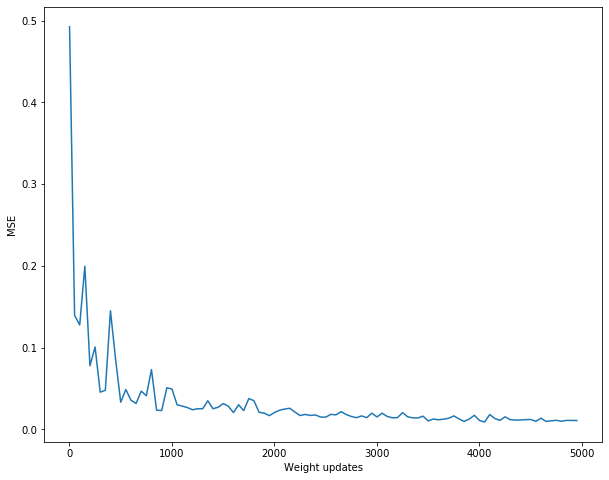

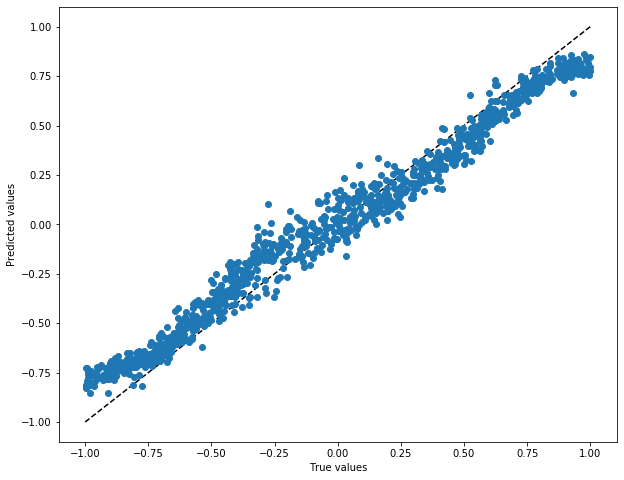

In [9]:
model = RNN(input_size=1, hidden_size=10, output_size=1)
data_generator = generate_samples(batch_size=1024, seq_length=10)

learner = Learner(model=model, loss_obj=loss_obj, data_generator=data_generator)
learner.train(iter_steps=5000, lr=1e-2, log_steps=50)
learner.plot_loss()
_ = learner.make_predictions(n_batches=1)
learner.scatter_plot()

# Train LSTMs with different sequence lengths

In [10]:
learners_rep = defaultdict(list)
seq_lens = [2, 5, 10, 15, 20]
for seq_len in seq_lens:
    for _ in range(5): # repeat 5 times
        model = RNN(input_size=1, hidden_size=10, output_size=1)
        data_generator = generate_samples(batch_size=1024, seq_length=seq_len)

        learner = Learner(model=model, loss_obj=loss_obj, data_generator=data_generator)
        learner.train(iter_steps=3000, lr=1e-3, log_steps=50)
        learner.make_predictions(n_batches=10)
        learners_rep[seq_len].append(learner)

finished training


finished training


finished training


finished training


finished training


finished training


finished training


finished training


finished training


finished training


finished training


finished training


finished training


finished training


finished training


finished training


finished training


finished training


finished training


finished training


finished training


finished training


finished training


finished training


finished training


# Visualization of different parameters

<ipython-input-11-902d7f62b803>:61: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


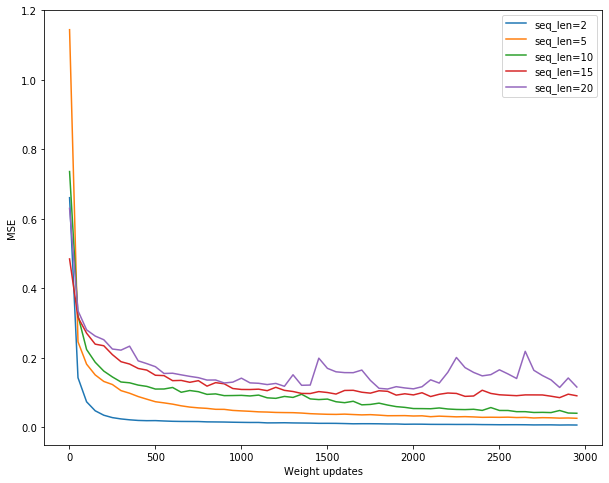

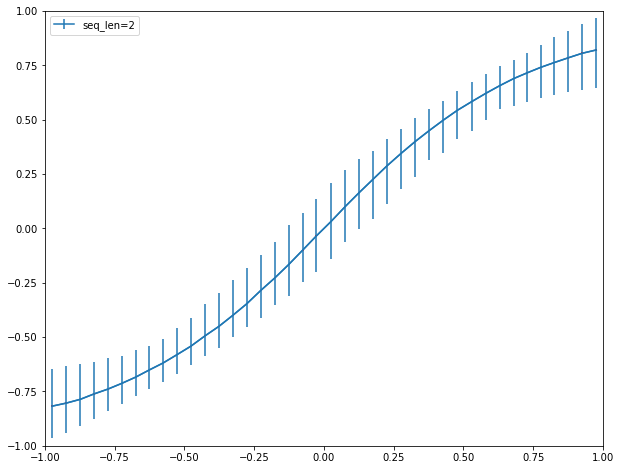

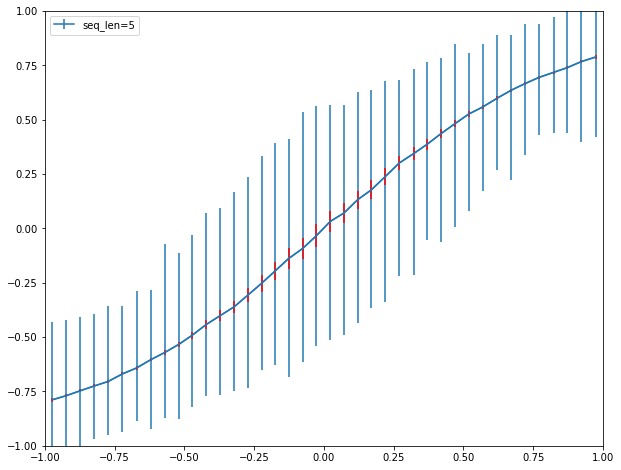

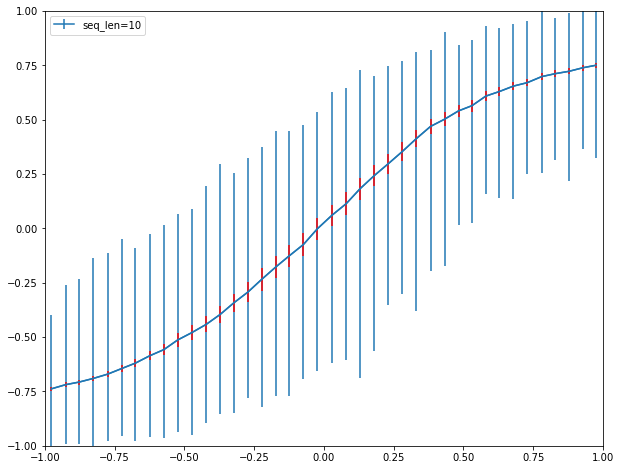

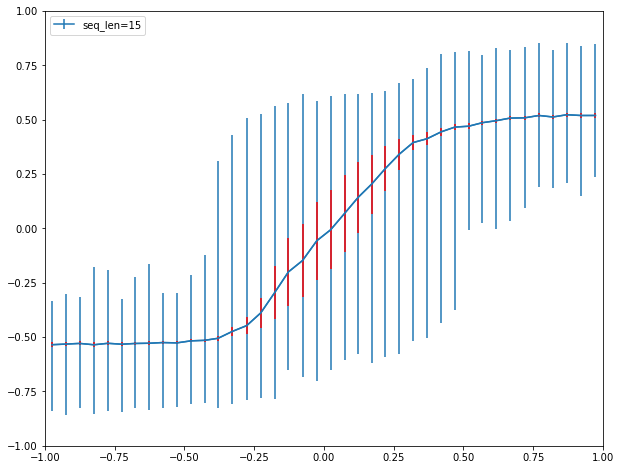

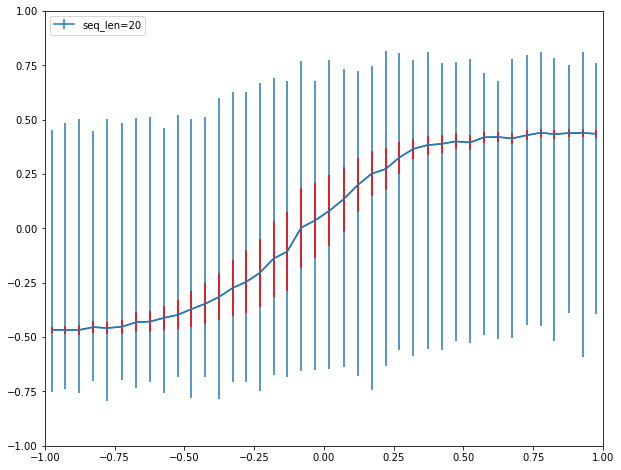

In [11]:
def plot_loss(learners: Dict[int, List[Learner]], figsize: Tuple[float, float]=(10, 8)):
    """Plot training loss curves.

    Parameters
    ----------
    learners: Dict[int, Learner]
        A dictionary of seq_len : Learner
    figsize : Tuple[float, float]
        Matplotlib figure size, by default (10,8)
    """
    fig, ax = plt.subplots(figsize=figsize)
    for seq_len, learner in sorted(learners.items()):
        # average over the loss-values (keys + values)
        k = np.mean([list(l.loss_values.keys()) for l in learner], axis=0)
        v = np.mean([list(l.loss_values.values()) for l in learner], axis=0)
        ax.plot(k, v, label = "seq_len="+str(seq_len))
    ax.set_xlabel("Weight updates")
    ax.set_ylabel("MSE")
    ax.legend()

def error_plot(learners: Dict[int, List[Learner]],figsize: Tuple[float, float]=(10, 8), nr_clusters=40):
    """Scatter plot of true vs predicted values.

    Parameters
    ----------
    learners: Dict[int, Learner]
        A dictionary of seq_len : Learner
    figsize : Tuple[float, float]
        Matplotlib figure size, by default (10,8)
    """
    
    for seq_len, learner in learners.items():
        # take all 10 into account
        y_trues = np.array([l.y_trues for l in learner]).flatten()
        y_hats = np.array([l.y_hats for l in learner]).flatten()
        # create a dict from y_true -> y flat
        oth = {k:v for k,v in zip(y_trues, y_hats)}
        # sort this dict
        soth = {k: oth[k] for k in sorted(oth.keys())}

        # split sorted keys and values into clusters
        ytc = np.split(np.array(list(soth.keys())), nr_clusters)
        yhc = np.split(np.array(list(soth.values())), nr_clusters)

        # take cluster means for line-pos
        x = np.mean(ytc, axis=1)
        y = np.mean(yhc, axis=1)
        # take std as measure of error, as mean+/-std
        # shape(2,N): Separate - and + values for each bar. First row
        yerr = np.stack((y-np.min(yhc, axis=1), -(y-np.max(yhc, axis=1))))
        yvar = np.var(yhc, axis=1)

        fig, ax = plt.subplots(figsize=figsize)
        label = "seq_len="+str(seq_len)
        # errorbars for range
        ax.errorbar(x, y, yerr=yerr, label = label)
        # errorbars for variance in red
        ax.errorbar(x, y, yerr=yvar, ecolor="red")
        ax.set_xlim([-1,1])
        ax.set_ylim([-1,1])
        fig.show()
        ax.legend(loc='upper left')

plot_loss(learners_rep)
error_plot(learners_rep)

# Visualization: Vanishing gradient

In [12]:
learners = {}
for seq_len in range(1,31, 2): # steps of 2 to speed it up
    model = RNN(input_size=1, hidden_size=10, output_size=1)
    data_generator = generate_samples(batch_size=1024, seq_length=seq_len)

    learner = Learner(model=model, loss_obj=loss_obj, data_generator=data_generator)
    learner.train(iter_steps=3000, lr=1e-3, log_steps=50)
    learner.make_predictions(n_batches=10)
    learners[seq_len] = learner

first_key = list(learners.keys())[0]
learner = learners[first_key]
avg_gradient = {"d_"+k: defaultdict(int) for k in learner.model.get_weights().keys()}
for seq_len, learner in learners.items():
    pred = learner.make_predictions(1)
    for p in pred[0]:
        grads = learner.model.backward(p)
        for name, g in grads.items():
            avg_gradient[name][seq_len] += np.mean(np.abs(g))

finished training


finished training


finished training


finished training


finished training


finished training


finished training


finished training


finished training


finished training


finished training


finished training


finished training


finished training


finished training


Average weights


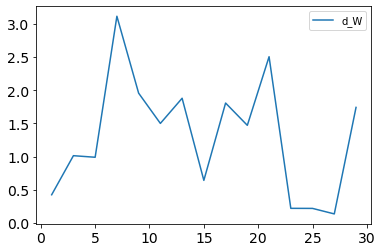

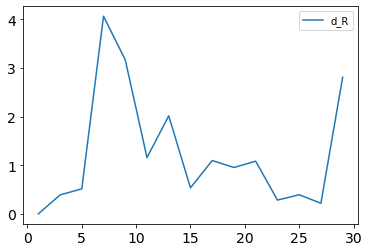

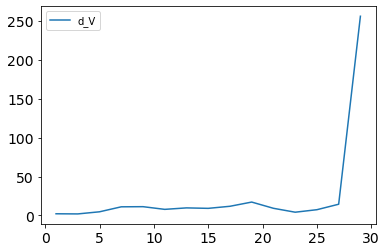

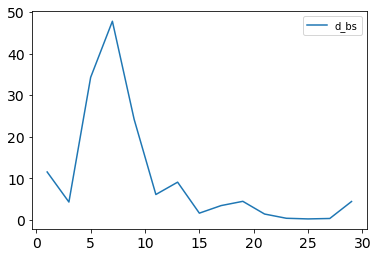

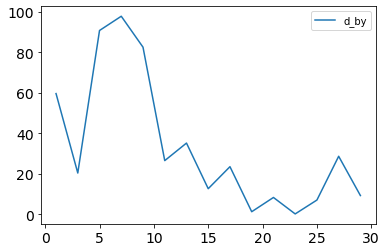

In [13]:
print("Average weights")
for name, g in avg_gradient.items():
    plt.plot(list(g.keys()), list(g.values()), label=name)
    plt.xlabel="Sequence length"
    plt.ylabel="Average weight"
    plt.legend()
    plt.tick_params(axis='both',labelsize=14)
    plt.show()